# Regression Trees

[<font color='#E8800A'>1 - Cost-Complexity Pruning</font>](#one-bullet) <br>
[<font color='#E8800A'>2 - ROC Curve and Precision Recall Curve for Classification problems</font>](#three-bullet) <br>
[<font color='#E8800A'>3 - The GridSearch</font>](#four-bullet) <br>

[<font color='#E8800A'>4 - Regression Trees (EXERCISE)</font>](#five-bullet) <br>
    [<font color='#E8800A'>4.1. - Building a Regression Tree</font>](#six-bullet) <br>
    [<font color='#E8800A'>4.2. - Changing the splitting criteria in regression trees</font>](#seven-bullet) <br>
    [<font color='#E8800A'>4.3. - Evaluate feature importances</font>](#eight-bullet) <br>
    [<font color='#E8800A'>4.4. - Apply GridSearchCV in your regression tree</font>](#nine-bullet) <br>
    




In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.model_selection import KFold
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt
# in anaconda prompt: conda install python-graphviz
# !pip install pydotplus
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

<div class="alert alert-block alert-info">
<a class="anchor" id="one-bullet"> 
    
# 1. Postpruning a tree
</a>    
</div>

### <font color='#E8800A'>ccp_alpha |</font> <font color='#3a7f8f'>Choose the complexity parameter used for Minimal Cost-Complexity Pruning.</font> <a class="anchor" id="first-bullet"></a><br><br>`default = '0.0'`

The DecisionTreeClassifier class in sklearn provides ccp_alpha as a parameter for post pruning. 
- The parameter __`ccp_alpha`__ provides a threshold for effective alphas, i.e. the process of pruning continues until the minimal effective alpha of the pruned tree is not greater than ccp_alpha. 
- The DecisionTreeClassifier class also provides a method __`cost_complexity_pruning_path`__ which implements the pruning process and returns the effective alphas(and the corresponding impurities of the pruned trees)
- The effective alpha is computed for each non-terminal node of the tree and the node with the weakest effective alpha(minimum) is pruned. This procedure is repeated recursively until there is only one node(the root node) left.

__`GOAL`__ To find an optimal value of effective alpha which gives the maximum validation/test set accuracy.

__`Step 1`__ <br>
- a) Create an instance of a DecisionTreeClassifier named as __dt_alpha__ and define the __random_state = 0__ <br>
- b) Compute the pruning path during Minimal Cost-Complexity Pruning by using the method __cost_complexity_pruning__ in your model and name the result as path
- c) From __path__, get the values of ccp_alphas by calling the attribute __.ccp_alphas__ and get the values of impurities by calling the attribute __.impurities__


In [2]:
diabetes = pd.read_csv(r'./Datasets/diabetes.csv')
X = diabetes.iloc[:,:-1]
y = diabetes.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15, stratify = y)

In [3]:
dt_alpha = DecisionTreeClassifier(random_state=0)
path = dt_alpha.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

__`Step 2`__ - Create a plot, where in x you should represent the alphas and in y the impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

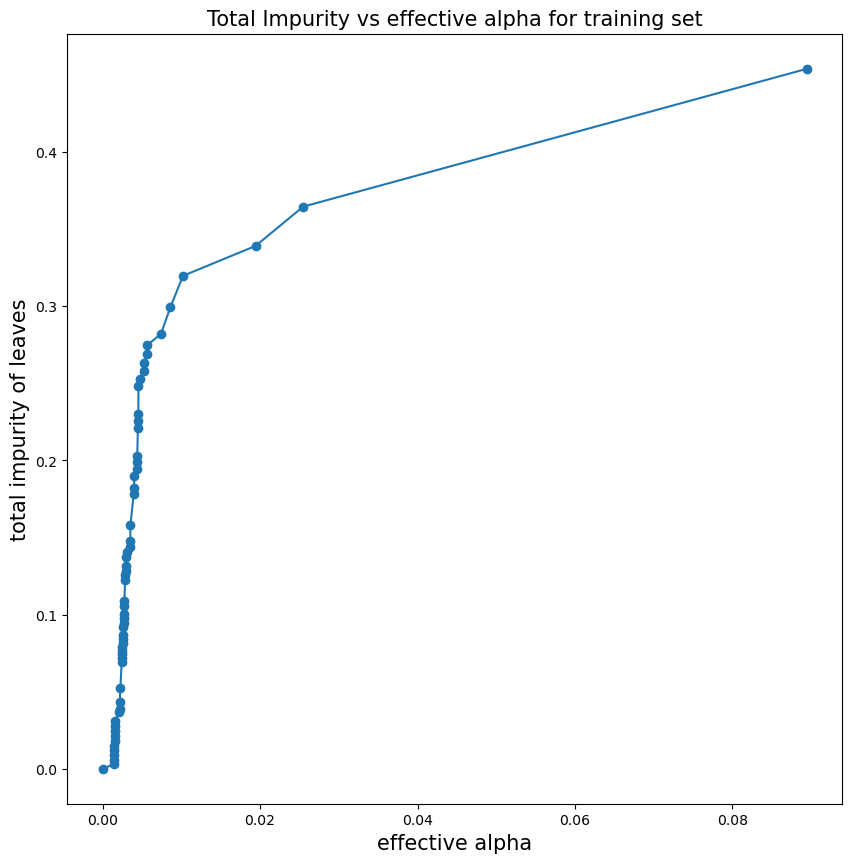

In [4]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(ccp_alphas, impurities, marker='o')
ax.set_xlabel("effective alpha", fontsize=15)
ax.set_ylabel("total impurity of leaves", fontsize=15)
ax.set_title("Total Impurity vs effective alpha for training set", fontsize=15)

The zero value of alpha corresponds to minimum impurity(unpruned tree) and as the value of alpha tends to infinity the tree tends to be more impure.

__`Step 3`__ - Build a forest of trees with different values of ccp_alpha values extracted from cost_complexity_pruning_path in order. The last tree will be the root node.

In [5]:
trees = []
for ccp_alpha in ccp_alphas:
    dt_alpha = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    trees.append(dt_alpha)

__`Step 4`__ - Plot the number of nodes and the tree depth as alpha increases.

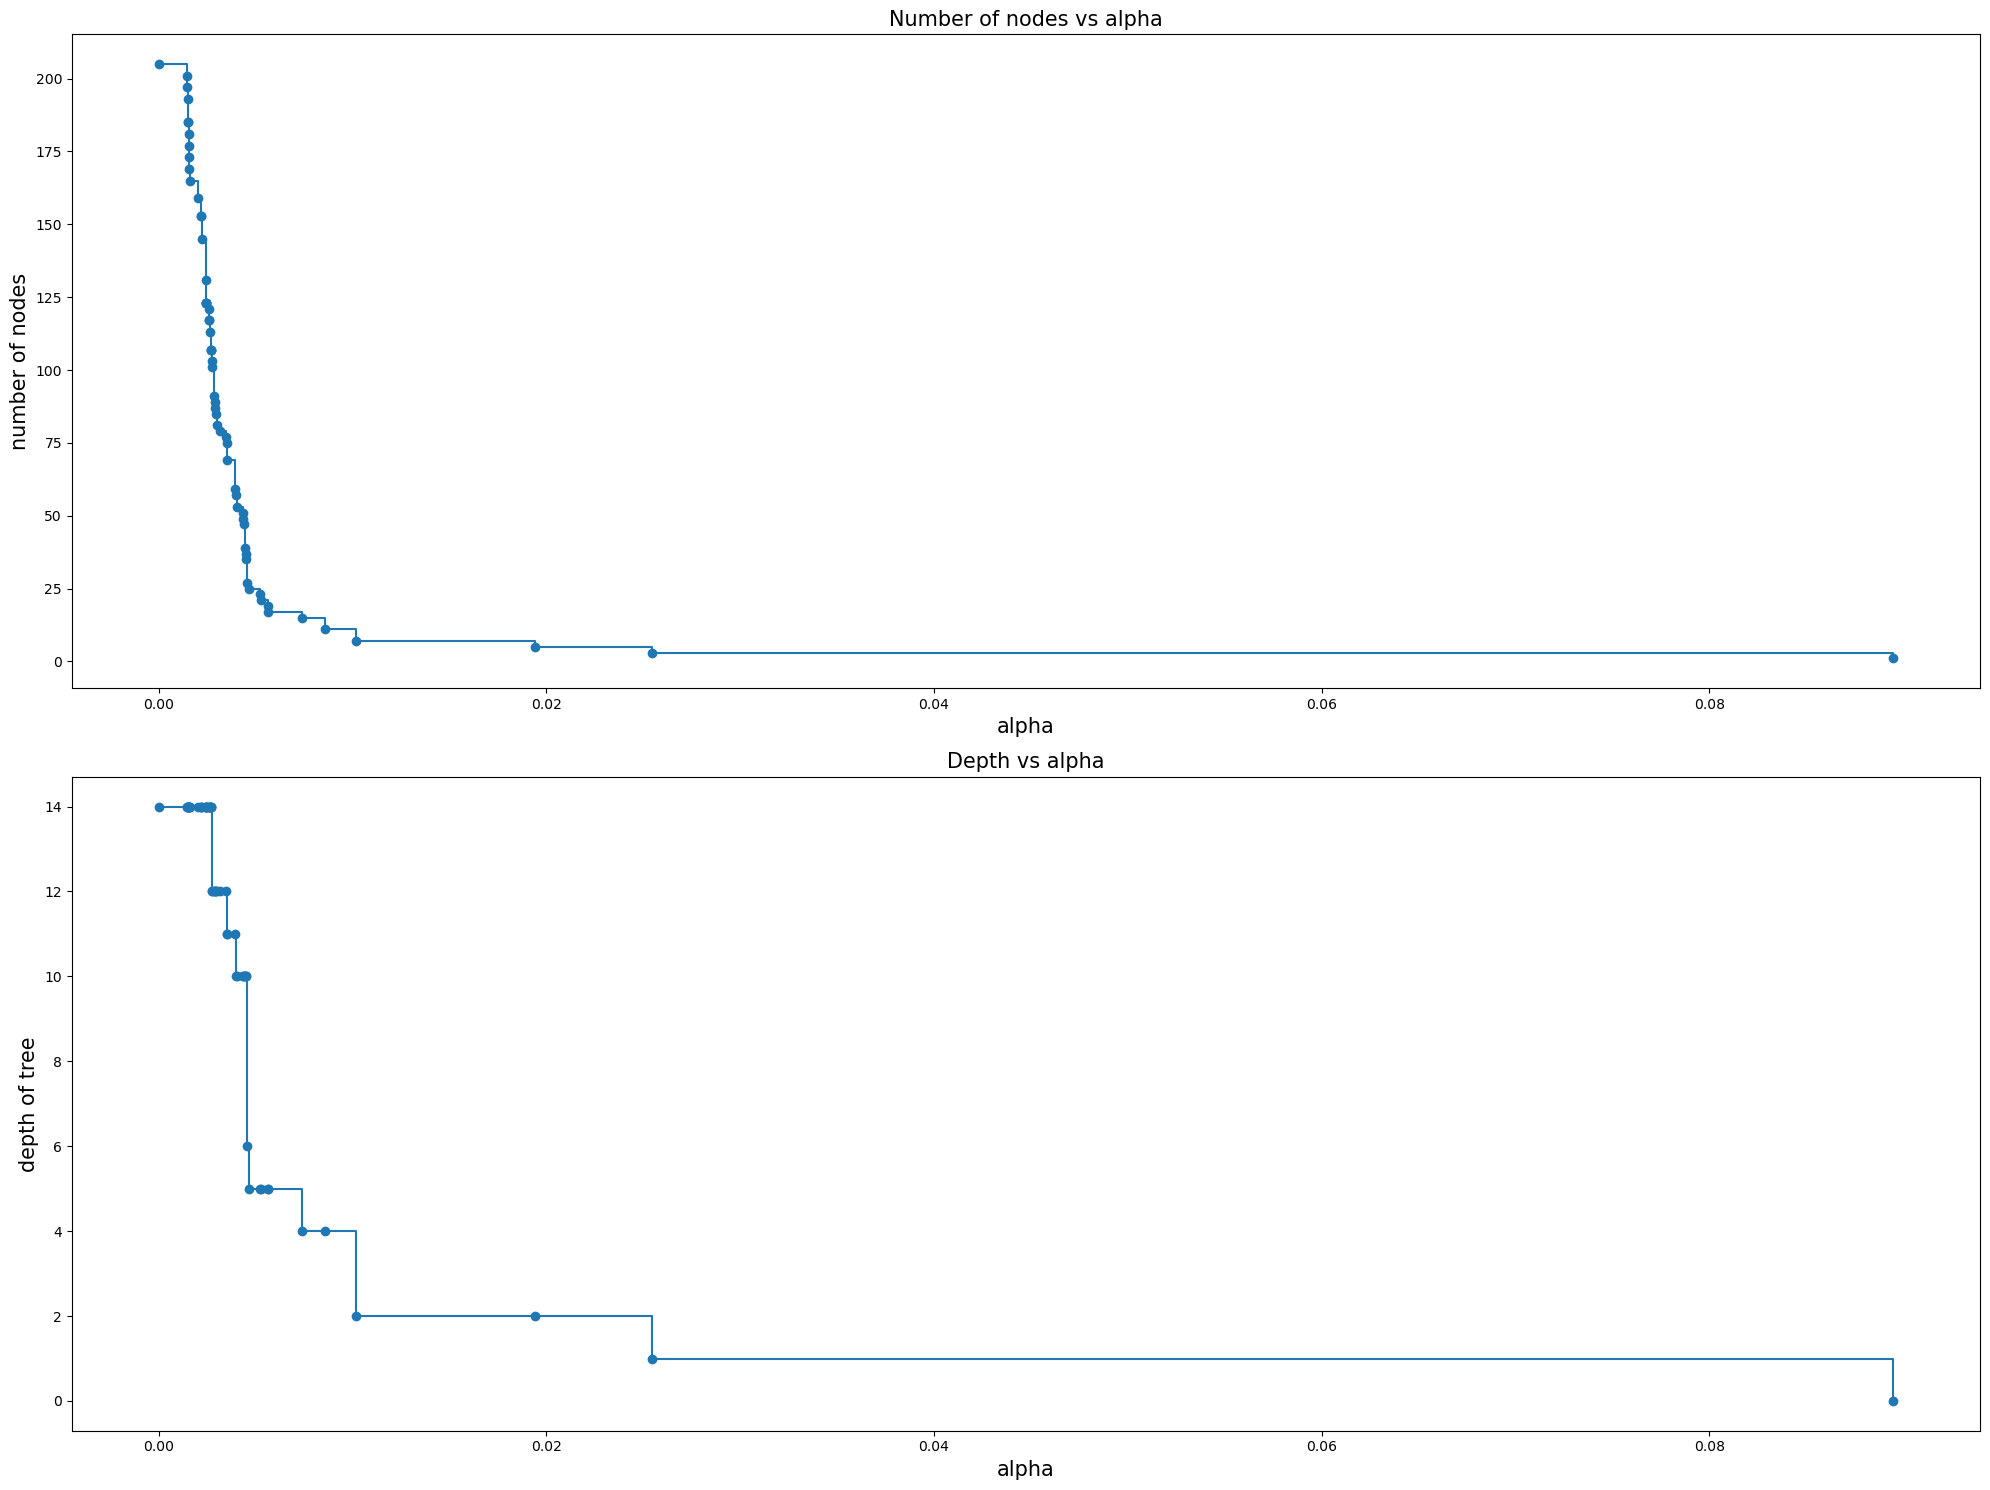

In [6]:
node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.get_depth() for tree in trees]

fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha", fontsize=15)
ax[0].set_ylabel("number of nodes", fontsize=15)
ax[0].set_title("Number of nodes vs alpha", fontsize=15)
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha", fontsize=15)
ax[1].set_ylabel("depth of tree", fontsize=15)
ax[1].set_title("Depth vs alpha", fontsize=15)
fig.tight_layout()

The plot shows that with the zero value of effective alpha the tree generated has the highest number of nodes and is the deepest(grows to the maximum), while as the effective alpha increases the trees are more pruned and have relatively fewer nodes and less deeper.

__`Step 5`__ - Check the mean accuracy associated to the train and the test dataset according to the different values of alphas.

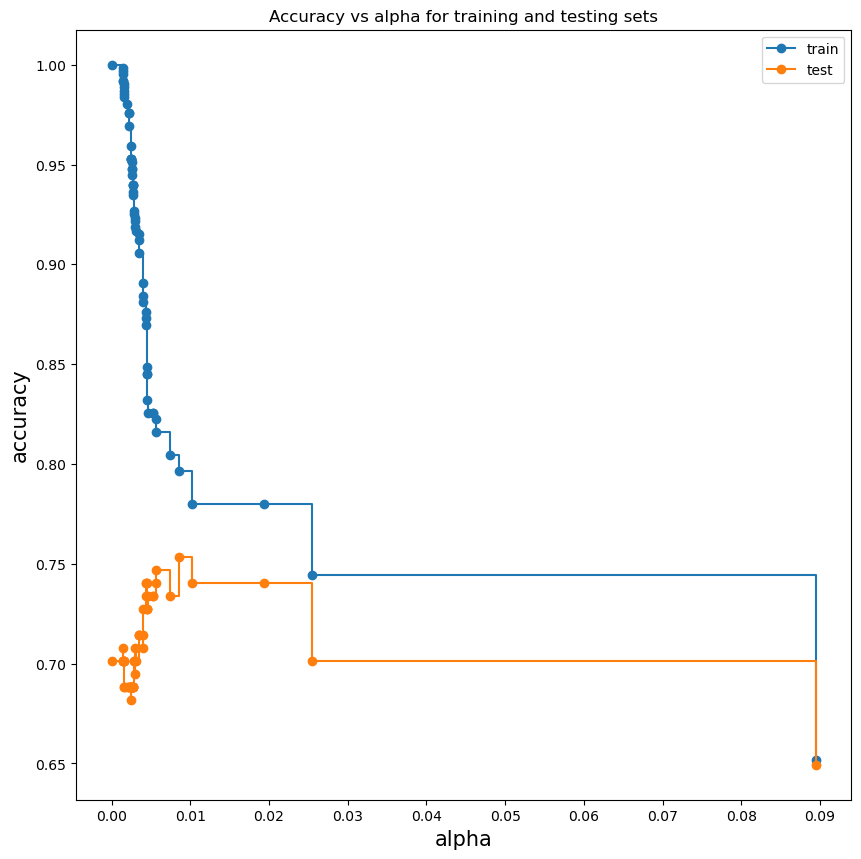

In [7]:
train_scores = [tree.score(X_train, y_train) for tree in trees]
test_scores = [tree.score(X_test, y_test) for tree in trees]

fig, ax = plt.subplots(figsize = (10,10))
ax.set_xlabel("alpha", fontsize=15)
ax.set_ylabel("accuracy", fontsize=15)
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
plt.xticks(np.arange(0,0.1,0.01))
ax.legend()
plt.show()

- With the initial smaller values of alpha, there is a huge disparity between the training and test accuracy scores. When the alpha value increases, the training accuracy decreases, and the test accuracy increases until we reach the optimal point(highest test accuracy score). <br>
- In the plot, the optimal point lies between 0.008 to 0.010 of alpha, where we get the optimal pruned tree. Beyond this point with an increase in alpha, the tree is over pruned. This eventually leads to under-fitting, both the training and test accuracy scores decrease.

__`Step 6`__ Check the best alpha for the best model according to the test scores and the scores associated to the train and the test by using the best ccp_alpha.

In [8]:
index_best_model = np.argmax(test_scores)
best_model = trees[index_best_model]
print('ccp_alpha of best model: ',trees[index_best_model])
print('_____________________________________________________________')
print('Training accuracy of best model: ',best_model.score(X_train, y_train))
print('Test accuracy of best model: ',best_model.score(X_test, y_test))

ccp_alpha of best model:  DecisionTreeClassifier(ccp_alpha=0.00860695851246833, random_state=0)
_____________________________________________________________
Training accuracy of best model:  0.7964169381107492
Test accuracy of best model:  0.7532467532467533


<div class="alert alert-block alert-info">
<a class="anchor" id="three-bullet">     

# 2. ROC Curve and Precision Recall Curve for Classification problems
</a>    
</div>

### Ploting the the ROC Curve for Classification Trees

- The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.
- The higher TPR and the lower FPR is for each threshold the better and so classifiers that have curves that are more top-left-side are better.
- You should use it when you care about ranking predictions and not necessarily about outputting well-calibrated probabilities.
- You should use it when you care equally about positive and negative classes. If we care about true negatives as much as we care about true positives then it can make sense to use ROC AUC.

In [9]:
modelDT = DecisionTreeClassifier().fit(X_train, y_train)
modelDT_entropy = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train)
modelDT_maxdepth3 = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
modelDT_leafs8 = DecisionTreeClassifier(max_leaf_nodes=8).fit(X_train, y_train)

At this moment, we have 4 classification trees built. We are going to plot the precision recall curve and the ROC Curve to those models.

__`Step 8`__ Import roc_curve from sklearn.metrics

In [10]:
from sklearn.metrics import roc_curve

__`Step 9`__ Use the `.predict_proba()` method of `modelDT` to obtain the probability estimates for the `X_test` and assign it to the object `prob_modelDT`. Do the same for the other models, and assign it to `prob_modelDT_entropy`, `prob_modelDT_maxdepth3` and `prob_modelDT_leafs8`

In [11]:
prob_modelDT = modelDT.predict_proba(X_test)
prob_modelDT_entropy =  modelDT_entropy.predict_proba(X_test)
prob_modelDT_maxdepth3 =  modelDT_maxdepth3.predict_proba(X_test)
prob_modelDT_leafs8 =  modelDT_leafs8.predict_proba(X_test)

__`Step 10`__ Call roc_curve() for the four different models. In this way, you should: <br>
1) For the first roc curve, call the roc_curve metric and assign the parameters `y_true` equal to `y_test` and `y_score` equal to `prob_modelDT[:, 1]`. Assign the results to `fpr_DT`, `tpr_DT`, `thresholds_DT`. <br>
2) Repeat the same procedure to the remaining models, changing the names of the objects accordingly.

In [12]:
fpr_DT, tpr_DT, thresholds_DT = roc_curve(y_test, prob_modelDT[:,1])
fpr_DT_ent, tpr_DT_ent, thresholds_DT_ent = roc_curve(y_test, prob_modelDT_entropy[:,1])
fpr_DT_depth3, tpr_DT_depth3, thresholds_DT_depth3 = roc_curve(y_test, prob_modelDT_maxdepth3[:,1])
fpr_DT_leafs8, tpr_DT_leafs8, thresholds_DT_leafs8 = roc_curve(y_test, prob_modelDT_leafs8[:,1])

__`Step 11`__ The purpose of this step is to plot the roc curve associated to each model. Do the following instructions in only one single cell, so the four plots appear in the same visualization. <br>
1) Import pyplot as plt from matplotlib <br>
2) Create a plot using the function `plt.plot()`, where the data to be represented is going to be the `fpr_DT`, `tpr_DT`, and the parameter label is going to be `label="ROC Curve modelDT"` <br>
3) Similarly to the previous step, plot now the values regarding `modelDT_entropy` <br>
4) Similarly to the previous step, plot now the values regarding `modelDT_maxdepth3` <br>
5) Similarly to the previous step, plot now the values regarding `modelDT_leafs8` <br>
6) call the function plt.legend()
7) Call the function plt.show()

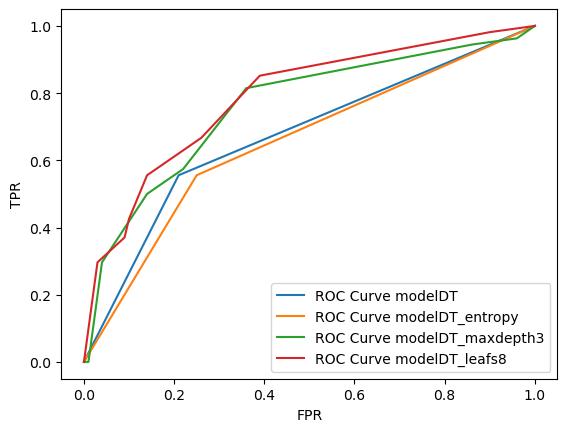

In [13]:
import matplotlib.pyplot as plt
plt.plot(fpr_DT, tpr_DT,label="ROC Curve modelDT")
plt.plot(fpr_DT_ent, tpr_DT_ent, label="ROC Curve modelDT_entropy")
plt.plot(fpr_DT_depth3, tpr_DT_depth3, label="ROC Curve modelDT_maxdepth3")
plt.plot(fpr_DT_leafs8, tpr_DT_leafs8, label="ROC Curve modelDT_leafs8")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

__`Step 12`__ The purpose of this step is to plot the precision recall curve associated to the best model obtained in the ROC Curve. <br>
1) Import precision_recall_curve from sklearn.metrics<br>
2) Get the precision, the recall and the thresholds from your precision recall curve<br>
3) Check what is the threshold for the best f1 score<br>
4) Plot the precision recall curve and the best threshold.<br>

Best Threshold=0.292453, F-Score=0.662


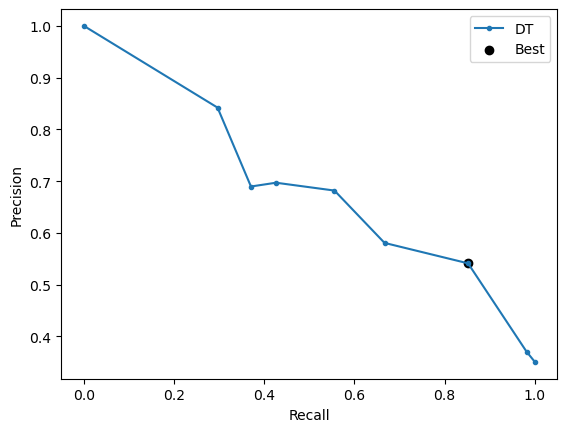

In [14]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, prob_modelDT_leafs8[:,1])

# apply f1 score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

plt.plot(recall, precision, marker='.', label='DT')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
<a class="anchor" id="four-bullet">     

# 3. The GridSearch
</a>    
</div>

__`Step 13`__ From sklearn.model_selection import __GridSearchCV__

In [15]:
from sklearn.model_selection import GridSearchCV

__`Step 14`__ Define a dictionary named as __parameter_space__ and define the following options to be considered during modelling:
- 'max_depth': [2,3,4,5,6]
- 'criterion': ['gini', 'entropy']
- 'splitter': ['random', 'best']
- 'max_features': [2,4,6,8,None]
- 'max_leaf_nodes': [4,8,12,None]

In [16]:
parameter_space = {
    'max_depth': [2,3,4,5,6],
    'criterion': ['gini', 'entropy'],
    'splitter': ['random', 'best'],
    'max_features': [2,4,6,8, None],
    'max_leaf_nodes': [4,8,12, None]
}

__`Step 15`__ Create an instance of GridSearchCV named as __clf__ and pass as parameters the __model__ and the __parameter_space__

In [17]:
clf = GridSearchCV(modelDT, parameter_space, scoring = 'f1')

__`Step 16`__ Fit your instance to __X_train__ and __y_train__

In [18]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6],
                         'max_features': [2, 4, 6, 8, None],
                         'max_leaf_nodes': [4, 8, 12, None],
                         'splitter': ['random', 'best']},
             scoring='f1')

__`Step 17`__ Call the attribute __best_params___ to check which is the best combination of parameters

In [19]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 4,
 'max_leaf_nodes': 8,
 'splitter': 'best'}

__`Step 18`__ Create a loop to check the mean and the standard deviation of the different models created using the different combinations using GridSearchCV

In [20]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'criterion': 'gini', 'max_depth': 6, 'max_features': 4, 'max_leaf_nodes': 8, 'splitter': 'best'}
------------------------------------------------------------------------------------------------------------------------
0.227 (+/-0.168) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'max_leaf_nodes': 4, 'splitter': 'random'}
0.322 (+/-0.193) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'max_leaf_nodes': 4, 'splitter': 'best'}
0.225 (+/-0.131) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'max_leaf_nodes': 8, 'splitter': 'random'}
0.495 (+/-0.098) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'max_leaf_nodes': 8, 'splitter': 'best'}
0.272 (+/-0.116) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'max_leaf_nodes': 12, 'splitter': 'random'}
0.424 (+/-0.206) for {'criterion':

<div class="alert alert-block alert-info">
<a class="anchor" id="five-bullet">     

# 4. Regression Trees (EXERCISE)
</a>    
</div>

In [21]:
def avg_score(model):
    # apply kfold
    kf = KFold(n_splits=10)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    for train_index, test_index in kf.split(X):
        # get the indexes of the observations assigned for each partition
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_test,y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test)

def plot_tree(model):
    dot_data = export_graphviz(model,
                               feature_names=X_train.columns,
                               filled=True)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.set_size('"20,20"')
    return graphviz.Source(pydot_graph.to_string())

def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test = avg_score(arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test
        count+=1
    return df

<div class="alert alert-block alert-success">
<a class="anchor" id="six-bullet">    

### 4.1. Building a Regression Tree
 </a>
    
</div>

__`Step 1`__ - From sklearn.tree import DecisionTreeRegressor

In [23]:
from sklearn.tree import DecisionTreeRegressor

__`Step 2`__ - Import the dataset `Boston.csv` and save it in an object named as `boston`. <br>
Define your independent variables as `X` and your target as `y`(column 'medv'). <br> Split your dataset into train and validation using train_test_split, where `train_size = 0.8` and `random_state = 15`.

In [39]:
boston = pd.read_csv("./Datasets/Boston.csv")
X = boston.iloc[:,:-1]
y = boston.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 15)

__`Step 3`__ - Create an instance of DecisionTreeRegressor with the default parameters and name it as __dt_mse__ and fit to your training data.

In [40]:
dt_mse = DecisionTreeRegressor().fit(X_train, y_train)

__`Step 4`__ __Predicted Values__ <br>
a) Check the predicted values for the validation dataset using the method __predict()__ in your model<br>

In [41]:
dt_mse.predict(X_test)

array([24.8, 50. , 16. , 20.6, 19.2, 13.8, 20. , 27.5, 28.6, 17.4, 14.1,
       24.3, 19.3, 14.9, 20.9, 15.6,  5. , 10.2, 21. , 27.1, 50. , 15.6,
       19.3, 19.4, 20.6, 22.6, 23.5, 17.7, 19.2, 22.2, 20.7, 14.4, 22.5,
       22. , 22.6, 21.2, 21.7, 31. , 15.4, 27.1, 43.8, 33.2, 15. , 23.2,
       20.6, 19.5, 17.3, 37.2, 22.6, 13.8, 34.9, 13.1, 15.2,  7.2, 16.6,
       34.9, 10.5, 31.7, 19.1, 30.1, 19.1, 28.7, 19.5, 27.5, 37.3, 19.5,
       15.3, 18.7, 22.6, 14.1, 20. , 25. , 22.5, 23.2, 35.4, 29.8, 50. ,
       22.5, 14.2, 10.9, 17.3, 13.1, 50. , 32.2, 38.7, 14.1, 34.6, 16. ,
       20.5, 23.1, 37.2, 20.6, 46. , 18.7, 22. , 31.7, 17.2, 34.9, 22.5,
       19.6, 17.8, 10.8])

__`Step 5`__ Check the depth (__get_depth()__), the number of nodes (__.tree_.node_count__) and the number of leaves (__get_n_leaves()__) of the model __dt_mse__

In [42]:
print("DEPTH = ", dt_mse.get_depth())
print("NODES = ", dt_mse.tree_.node_count)
print("LEAVES = ", dt_mse.get_n_leaves())

DEPTH =  17
NODES =  759
LEAVES =  380


<div class="alert alert-block alert-success">
<a class="anchor" id="seven-bullet">    

### 4.2. Changing the splitting criteria
 </a>
    
</div>

### <font color='#E8800A'>criterion | </font>  <font color='#3a7f8f'>Changing the split criteria</font> <a class="anchor" id="first-bullet"></a><br><br>`default = 'mse' / 'squared_error' (version 1.2)`
    
- In most cases, the choice of splitting criteria will not make much difference in the performance of the model. However, and according to the "No free lunch Theorem", each criterion is superior in some cases and inferior in others.

__`Step 6`__ - Create an instance of DecisionTreeRegressor named as __dt_mae__ and define the parameter __criterion='mae'__ and __max_depth = 3__. Fit the data to your model. If using a version of sklearn equal or higher to 1.2, use __criterion='absolute error'__.

In [43]:
dt_mae = DecisionTreeRegressor(criterion='absolute_error', max_depth=3).fit(X_train, y_train)

__`Step 7`__ - Create an instance of DecisionTreeRegressor named as __dt_mse2__ and define the parameter __criterion='mse'__ and __max_depth = 3__. Fit the data to your model. If using a version of sklearn equal or higher to 1.2, use __criterion='squared_error'__.

In [44]:
dt_mse2 = DecisionTreeRegressor(criterion='squared_error', max_depth=3).fit(X_train, y_train)

__`Step 8`__ - Check the results (done for you)

In [46]:
df = pd.DataFrame(columns = ['Time','Train','Test'], index = ['mae','mse'])
show_results(df,dt_mae, dt_mse2)

,Time,Train,Test
mae,0.01+/-0.0,0.774+/-0.03,0.213+/-0.65
mse,0.001+/-0.0,0.827+/-0.01,-0.209+/-1.18


Why we are getting in some cases the value of test as negative? <br>
If the chosen model fits worse than a horizontal line, we can obtain values of r square negatives.

__`Step 9`__ - Plot the two trees (Ignore this step if you have not been able to install graphviz).

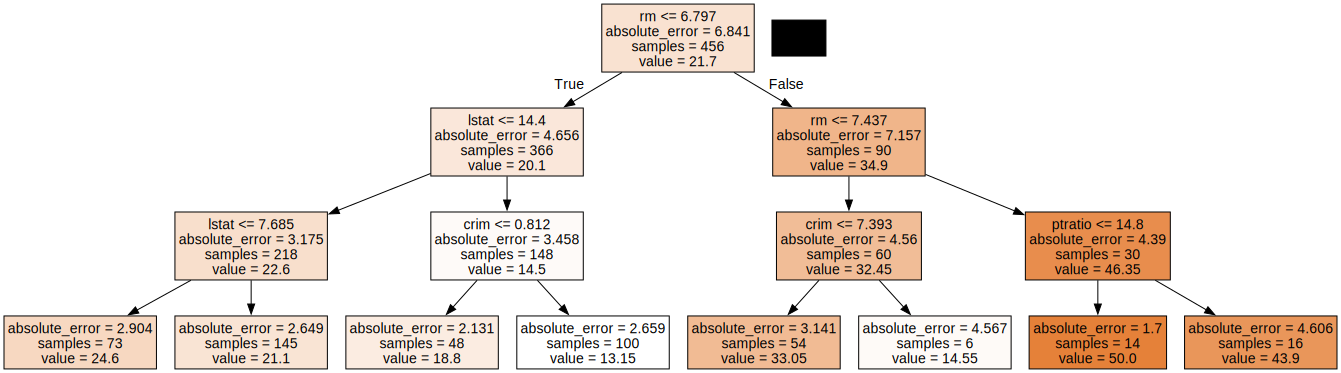

In [47]:
plot_tree(dt_mae)

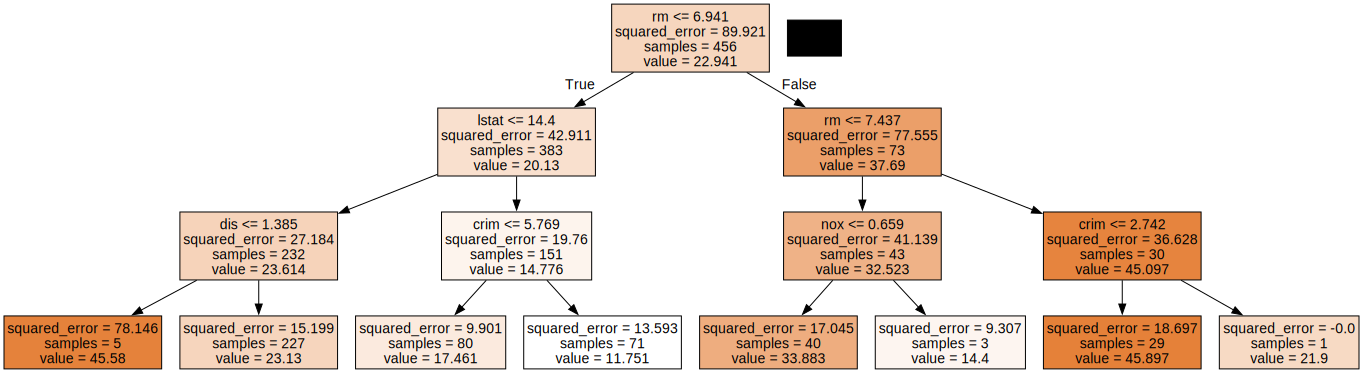

In [48]:
plot_tree(dt_mse2)

For more decision tree plots - Check https://github.com/parrt/dtreeviz

<div class="alert alert-block alert-success">
<a class="anchor" id="eight-bullet">    

### 4.3. Evaluate feature importance
 </a>
    
</div>

__`Step 10`__ Calculate the feature importance using the split criteria 'mse' and 'mae'.

In [51]:
mse_importance = dt_mse2.feature_importances_
mae_importance = dt_mae.feature_importances_

__`Step 11`__ Plot the feature importances for both criterions

<Axes: xlabel='Value', ylabel='Col'>

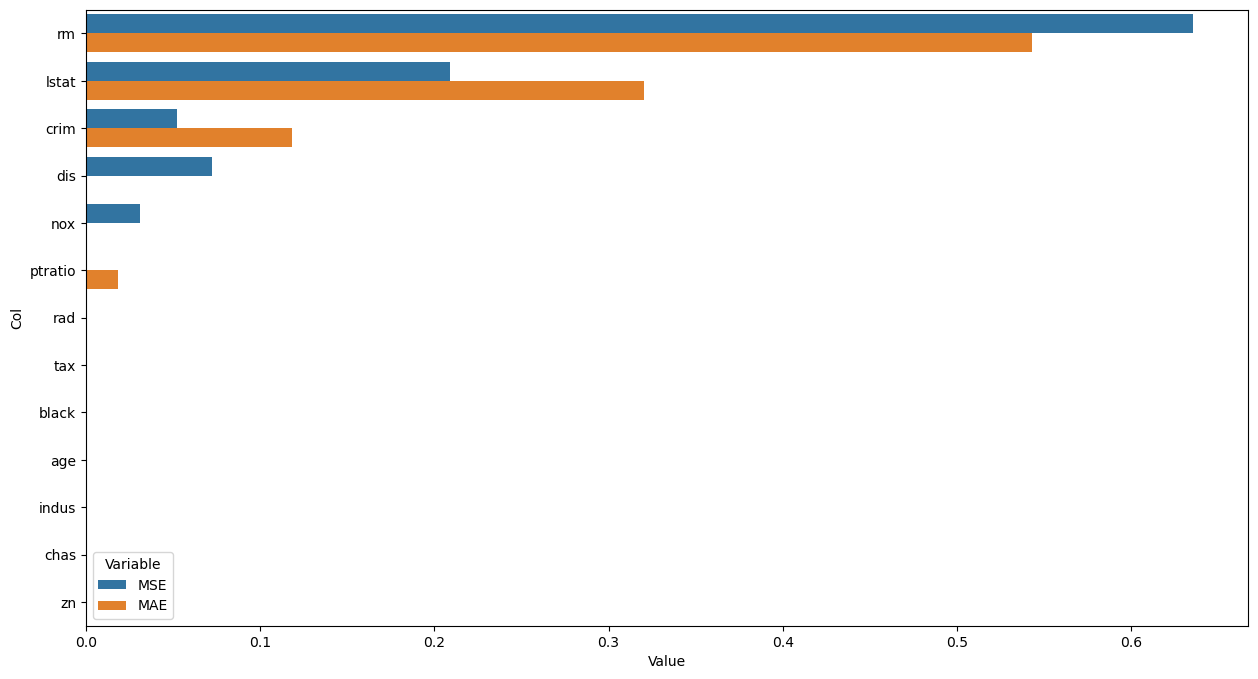

In [52]:
import seaborn as sns

zippy = pd.DataFrame(zip(mse_importance, mae_importance), columns = ['MSE','MAE'])
zippy['col'] = X_train.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

<div class="alert alert-block alert-success">
<a class="anchor" id="nine-bullet">    

### 4.4. Apply GridSearchCV in your regression tree
 </a>
    
</div>

__`Step 12`__ Define a parameter space with different values for different parameters and check what are the parameters for the best regression tree using r2. What is the r2 mean and the std for those parameters? <br>
Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [61]:
parameter_space = {
    'max_depth': [2,3,4,5,6],
    'criterion': ['squared_error', 'absolute_error'],
    'splitter': ['random', 'best'],
    'max_features': [2,4,6,8, None],
    'max_leaf_nodes': [4,8,12, None]
}

model = DecisionTreeRegressor()
clf = GridSearchCV(model, parameter_space, scoring = 'r2')
clf.fit(X_train, y_train)
# print(clf.cv_results_['mean_test_score'].mean())
# print(clf.cv_results_['std_test_score'].std())


DecisionTreeRegressor(max_depth=4)

In [63]:
clf.best_score_

0.8119343350484997